# Scenario 2: Measuring the stability of enzymes
Data provided by Amalie Vang Høst (Department of Chemical and Biochemical Engineering, Technical University of Denmark, 2800 Kgs Lyngby, Denmark)  
  
The datasets for this and all following scenarios were created by Simone Lauterbach. Usually, the project partners fill out an EnzymeML spreadsheet template, which is a structured Excel file with macros. Simone checked the spreadsheets for completeness and converted them into EnzymeML documents.  
In this scenario, the time-course data from the EnzymeML document is analysed visually, and initial rates are calculated. The analysis of initial rates is widespread by many of our project partners and in biocatalysis in general.  
This scenario is a reproduction of the analysis done by Vang Høst in Excel, which she provided us with.  
The initial rate analysis aims to investigate the stability of the enzyme glucose oxidase, characterised by activity loss over time in the experimental conditions. Measured was glucose oxidation to gluconolactone, which spontaneously hydrolyses to gluconic acid in water.

## Imports
First, all necessary Python packages must be installed and imported.  
This step is the same for all scenarios and differs only in the used python packages.
If you run this notebook with Binder, you don't have to install anything. Binder takes care of this.   
If you run this notebook locally, make sure you have all Packages installed. All needed packages with the used version can be found in the `requirements.txt` in the root GitHub directory (not in `\book`).

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np

from scipy import stats
from pyenzyme import EnzymeMLDocument

## Reading EnzymeML with PyEnzyme software
In order to read the EnzymeML document and access its content with the PyEnzyme software, the file path is defined.  
If you want to run this Jupyter Notebook locally, make sure you have the same folder structure or change the path accordingly.  
When running the following code cell, the EnzymeML document is saved in the `enzmlDoc` variable, and an overview is printed below.

In [2]:
path = '../../data/Host_Measurements_orig.omex'

# check for correct file path and file extension:
if os.path.isfile(path) and os.path.basename(path).lower().endswith('.omex'):
    enzmlDoc = EnzymeMLDocument.fromFile(path)
    enzmlDoc.printDocument(measurements=True)
else:
    raise FileNotFoundError(
        f'Couldnt find file at {path}.'
    )

Host_Measurements
>>> Reactants
	ID: s0 	 Name: Glucose
	ID: s1 	 Name: water
	ID: s2 	 Name: O2
	ID: s3 	 Name: 4-aminoantipyrine
	ID: s4 	 Name: 3,5-dichloro-2-hydroxybenzenesulfonic acid
	ID: s5 	 Name: Gluconic acid
	ID: s6 	 Name: pink product
>>> Proteins
	ID: p0 	 Name: Glucose Oxidase
>>> Complexes
>>> Reactions
	ID: r0 	 Name: Deactivation of glucose oxidase
>>> Measurements

ID    Species   Conc      Unit  
m0    p0        0.500   g / l   
m0    s0        1       mole / l
m0    s1        0       mole / l
m0    s2        0       mole / l
m0    s3        1       mole / l
m0    s4        10      mole / l
m0    s5        0       mole / l
m0    s6        0       mole / l
m1    p0        0.500   g / l   
m1    s0        1       mole / l
m1    s1        0       mole / l
m1    s2        0       mole / l
m1    s3        1       mole / l
m1    s4        10      mole / l
m1    s5        0       mole / l
m1    s6        0       mole / l
m2    p0        0.500   g / l   
m2    s0        1 

This experiment consists of eleven measurements and consisting of seven reactants (s0 -s6) and one protein (p0).  
For initial rate calculation, only  the time-course data is needed. Those are usually analysed in relation to different initial concentrations of the substrate. In this case, the stability of the enzyme is of interest. Therefore, all eleven measurements (m0 - m10) were carried out under identical conditions and with identical initial concentrations, but the time to add the substrate and start the reaction varied. This information was stored in the measurement names.  
Next, one measurement is exemplarily examined. 

In [3]:
# fetch the measurement
measurement0 = enzmlDoc.getMeasurement('m0')
measurement0.printMeasurementScheme()

>>> Measurement m0: Measurement after 0 min
    s0 | initial conc: 1.0 mole / l 	| #replicates: 0
    s1 | initial conc: 0.0 mole / l 	| #replicates: 0
    s2 | initial conc: 0.0 mole / l 	| #replicates: 0
    s3 | initial conc: 1.0 mole / l 	| #replicates: 0
    s4 | initial conc: 10.0 mole / l 	| #replicates: 0
    s5 | initial conc: 0.0 mole / l 	| #replicates: 3
    s6 | initial conc: 0.0 mole / l 	| #replicates: 0
    p0 | initial conc: 0.5 g / l 	| #replicates: 0


The overview of the initial measurement shows that the product gluconic acid (s5) has three replicates. These contain the measured time-course data.  

## Data preparation
In this experiment, to analyse the stability of the enzyme, only the change of the initial rates over time is of interest. Therefore only the measured time-course data and the measurement names containing the time information are stored for each measurement. To extract the information of the measurement time, string manipulation is used. 

In [4]:
# initialise datastructure to store experimental data
experimentalData = []

# time and substrate concentration unit
measurement = enzmlDoc.getMeasurement('m0')
time = np.array(measurement.global_time, float)
timeUnit = measurement.global_time_unit
concentrationUnit = ''

# go through all measurements:
for measurement in enzmlDoc.measurement_dict.values():
    name = measurement.name
    measurementData = {
        'name': name,
        'measuring time min': float(name.split(' ')[-2]),
        'measuring time h': float(name.split(' ')[-2])/60,
        'measured': []
    }

    # get replicates with time course data:
    reactant = measurement.getReactant('s5')
    
    for replicate in reactant.replicates:
        measurementData['measured'].append(replicate.data)
        
    experimentalData.append(measurementData)

## Visualisation of time-course data
All time-course data is visualised with the Python library Matplotlib.  
To save the figure as SVG uncomment the `plt.savefig(...)` code line.

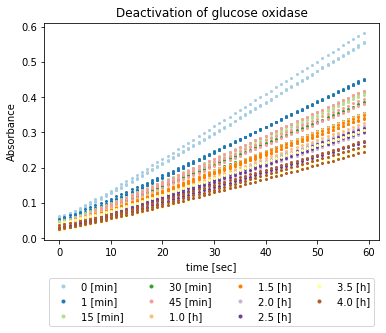

In [5]:
# define colors for time-course visualisation
colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#fdbf6f', \
          '#ff7f00','#cab2d6','#6a3d9a','#ffff99','#b15928']
# plot time course data with matplotlib
reaction_name = enzmlDoc.getReaction('r0').name
plt.figure()
ax = plt.subplot()
for i in range(len(experimentalData)):
    t = experimentalData[i]['measuring time min']
    if t < 60:
        ax.plot([], 'o', ms=3, label=str(int(t)) + ' [min]', color = colors[i])
    else:
        ax.plot([], 'o', ms=3, label=str(t/60) + ' [h]', color = colors[i])
    for measurement in experimentalData[i]['measured']:
        ax.plot(time, measurement, 'o', ms=2, color = colors[i])
plt.title(reaction_name)
ax.set_xlabel('time ['+timeUnit+']')
ax.set_ylabel('Absorbance')
plt.legend(bbox_to_anchor=(0, 0, 1, -0.15), mode="expand", ncol=4)
# save as svg
#plt.savefig('time-course.svg', bbox_inches='tight')
plt.show()

The visualisation shows that the curves were less steep the more time passed. The steep light blue curve shows that the time-courses are not entirely linear but starts with a lag phase.

## Computation of initial rates
To calculate the initial rates, the slope for each replicate is estimated from the first 30 data points (0 to 29 seconds) to be consistent with the calculations done by Vang Høst. This is done with linear regression by the Python library SciPy.  
To calculate the slope of another fraction of the time-course, change the `start` and `end` variable accordingly, `end` should not be greater than 59.  
Then the mean from the three replicates is calculated for each measurement and saved in `experimentalData`.  
With an extinction coefficient of 26 {cite}`Heuts2007`, the rates are determined according to Lambert-Beer law as follows:  
> $ rate = \frac{meanOfSlope}{26}*1000$  
>
and also stored in `experimentalData`.  
And finally, the residual activity compared to the initial activity is calculated and stored.

In [6]:
start = 0
end = 29
for measurement in experimentalData:
    slopes = []
    for replicate in measurement['measured']:
        slope, intercept, r, p, se = stats.linregress(time[start:end], replicate[start:end])
        slopes.append(slope)
    slope = np.mean(slopes)
    measurement['slope'] = round(slope, 4)
    measurement['v0'] =  round(slope/(26)*1000, 3)
    measurement['residual activity'] = measurement['v0']/experimentalData[0]['v0']*100

## Visualisation of the rates
First the rates are plotted over the time.

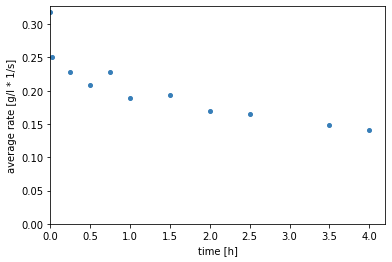

In [7]:
plt.figure()
ax = plt.subplot()
for measurement in experimentalData:
    ax.plot(measurement['measuring time h'], measurement['v0'], 'o', ms=4, color='#377eb8')
ax.set_xlabel('time [h]')
ax.set_ylabel('average rate [g/l * 1/s]')
ax.set_ylim(ymin=0)
ax.set_xlim(xmin=0)
# save as svg
# plt.savefig('rates.svg', bbox_inches='tight')
plt.show()

Second the residual of the rates is plotted.

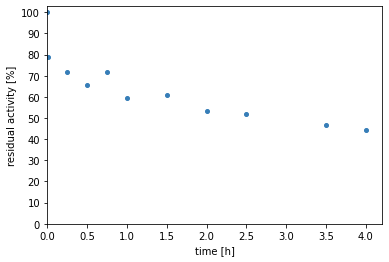

In [8]:
plt.figure()
ax = plt.subplot()
for measurement in experimentalData:
    ax.plot(measurement['measuring time h'], measurement['residual activity'], 'o', ms=4, color='#377eb8')
ax.set_xlabel('time [h]')
ax.set_ylabel('residual activity [%]')
ax.set_yticks(np.arange(0, 105, 10))
ax.set_xlim(xmin=0)
# save as svg
# plt.savefig('residual-activity.svg', bbox_inches='tight')
plt.show()

The figures show a decrease in the initial rates over time, which corresponds to the enzyme's activity. This suggests the instability of the enzyme in the given conditions. The greatest activity loss seems to happen very fast in the first minute.

## Upload to DaRUS 
Since this scenario is part of a momentarily written paper, it will be uploaded to a DataVerse on DaRUS, the data repository of the University of Stuttgart, and get a DOI. 